<a href="https://colab.research.google.com/github/mansine/Electricity-Consumption/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# loading the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping



# DATA PROCESSING

In [ ]:
#reading the dataset
df=pd.read_csv("/content/File1.txt",header = None,delimiter = ' ')
#adding columns in the data
df.columns = ['MeterID','DateTime','ElectricityConsumption']
#checking the range of DateTime column
df['DateTime'].min() , df['DateTime'].max()
#Keep the DataFrame with valid entries in the same variable.
df.dropna(inplace=True)
#seperating days and time from 5 digits DateTime columns
#Converting DateTime datatype from integer to string
df['DateTime'] = df['DateTime'].astype('str')
new = df['DateTime'].str.split("", n =0, expand = True)
#First 2digits are days in 2year readings
df['date'] = new[1] + new[2] + new[3] 
#Last 2digits showing time code
df['time_in_minutes'] = new[4] + new[5]
#No more need of duplicated data
df.drop('DateTime', axis=1, inplace=True)
#convert string to integer
df['date'] = df['date'].astype(int)
df['time_in_minutes'] = df['time_in_minutes'].astype(int)
# convert the mins to real time by multiplying it by 30 mins
df['time_in_minutes']=df['time_in_minutes']*30
df.isnull().sum()
#sorting the value in ascending order by MererID,date and time_in_minutes
df.sort_values(['MeterID','date','time_in_minutes'],ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True)

In [ ]:
#covert minutes data into hours
df['hours']=pd.to_datetime(df.time_in_minutes,unit ='m').dt.strftime('%H:%M')
#coverting days of year into actual date
year=2009
df['Date']=pd.to_datetime(df.date,unit='D', origin=str(year))
# Drop unwanted attributes
df=df.drop(['time_in_minutes', 'MeterID','date'], axis = 1)



```
# This is formatted as code
```

# Stationarity 

In [ ]:
#kilowatt consumption per day is aggregated
df=df.groupby(['Date']).agg('mean')


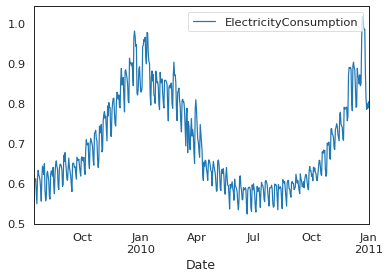

In [ ]:
df.plot()
plt.show()

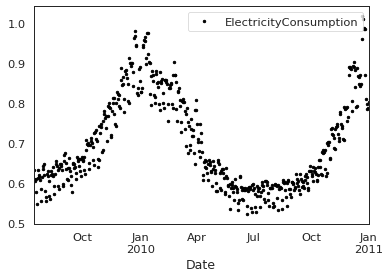

In [ ]:
df.plot(style='k.')
plt.show()

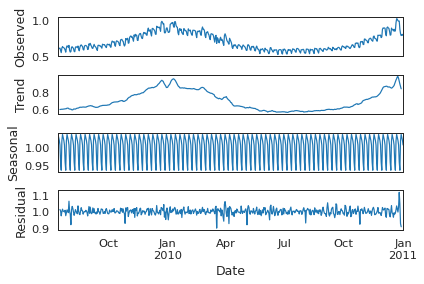

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

Data stationarity(Dickey Fuller Test)

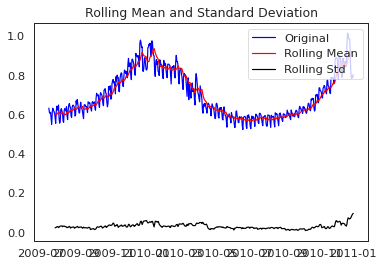

Results of dickey fuller test
Test Statistics                -0.7448
p-value                         0.8348
No. of lags used               14.0000
Number of observations used   521.0000
critical value (1%)            -3.4430
critical value (5%)            -2.8671
critical value (10%)           -2.5697
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['ElectricityConsumption'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df)

Null Hypothesis: The series has stationary.
Alternate Hypothesis: The series has no stationary.

In the above case p-value is greater than 0.05 and hence cannot reject the Null Hypothesis.Also, the test statistics is greater than the critical values. so the data is non-stationary.
The test statistics also exceed the critical values. Thus the data is not stationary. We need to eliminate the trend and the seasonality of the series to obtain a stationary series. We begin with the series log, which reduces the value magnitude and reduces the increasing trend in this series. Then we find the rolling average of the Series after the series log. By taking input for the last 12 months, a rolling average is calculated to give a mean consumption value in a further series at each point..

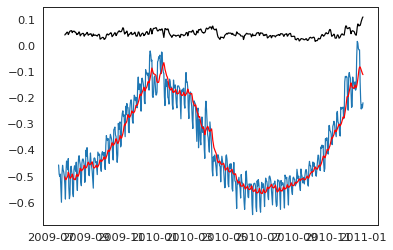

In [ ]:
import numpy as np
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.plot(df_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

After we find the mean, we take at every point in the series the difference and the mean. This way we remove trends from a range and get a more stationary range.

In [ ]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

Perform the Dickey-Fuller test (ADFT) once again.

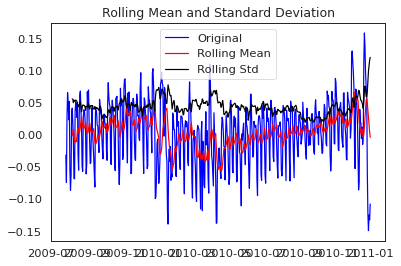

Results of dickey fuller test
Test Statistics                -3.7933
p-value                         0.0030
No. of lags used               14.0000
Number of observations used   510.0000
critical value (1%)            -3.4432
critical value (5%)            -2.8672
critical value (10%)           -2.5698
dtype: float64


In [ ]:
test_stationarity(df_log_moving_avg_diff)


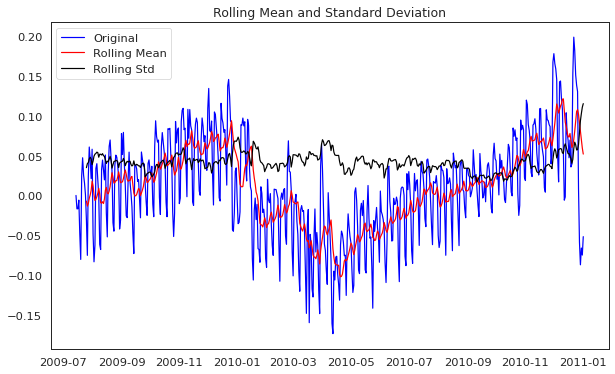

Results of dickey fuller test
Test Statistics                -1.7558
p-value                         0.4026
No. of lags used               14.0000
Number of observations used   521.0000
critical value (1%)            -3.4430
critical value (5%)            -2.8671
critical value (10%)           -2.5697
dtype: float64


In [ ]:
weighted_average = df_log.ewm(halflife=12, min_periods=0,adjust=True).mean()
logScale_weightedMean = df_log-weighted_average
from pylab import rcParams
rcParams['figure.figsize'] = 10,6
test_stationarity(logScale_weightedMean)

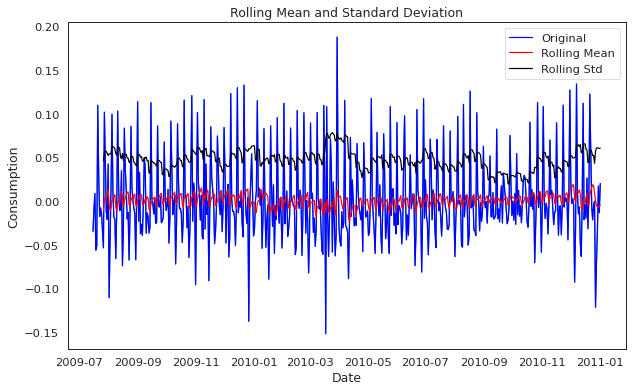

Results of dickey fuller test
Test Statistics                -7.1648
p-value                         0.0000
No. of lags used               13.0000
Number of observations used   521.0000
critical value (1%)            -3.4430
critical value (5%)            -2.8671
critical value (10%)           -2.5697
dtype: float64


In [ ]:
df_log_diff = df_log - df_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(df_log_diff)#Let us test the stationarity of our resultant series
df_log_diff.dropna(inplace=True)
test_stationarity(df_log_diff)

Now the above graph shows that data attained stationarity.

# LSTM with Data stationarity 

In [ ]:
dataset = df_log_diff.ElectricityConsumption.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

I tried to increase performance of my model and hence make changes on echos , batch_size and units of LSTM. The model performance shows best in the below configuration.

The model performance shows best in the below configuration.
1. batch_size = 30
2. epochs=100
3. Lstm units =12
> In the above configuration, the model attained accuracy = 79.46676015853882



In [ ]:
model = Sequential()
model.add(LSTM(12, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics='accuracy')

history = model.fit(X_train, Y_train, epochs=100, batch_size=30, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False )

model.summary()

Epoch 1/100
14/14 [==============================] - 2s 36ms/step - loss: 0.2556 - accuracy: 0.0016 - val_loss: 0.1282 - val_accuracy: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0995 - accuracy: 0.0016 - val_loss: 0.0382 - val_accuracy: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 0.0316 - accuracy: 0.0016 - val_loss: 0.0235 - val_accuracy: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 0.0238 - accuracy: 0.0000e+00 - val_loss: 0.0239 - val_accuracy: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 0.0227 - accuracy: 0.0000e+00 - val_loss: 0.0218 - val_accuracy: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0211 - accuracy: 0.0016 - val_loss: 0.0212 - val_accuracy: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0203 - accuracy: 0.0016 - val_loss: 0.0205 - v

Below is the accuracy of the model

In [ ]:
model.save('MusicalInstrumentReviews.h5')
Y_test_dummies = pd.get_dummies(Y_test).values
print('Shape of Label tensor: ', Y_test_dummies.shape)
# model evaluation
from keras.models import load_model

model = load_model('MusicalInstrumentReviews.h5')
scores = model.evaluate(X_test, Y_test_dummies)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', scores[1]*100, '%')

Shape of Label tensor:  (76, 76)
3/3 [==============================] - 0s 4ms/step - loss: 0.2157 - accuracy: 0.7947
Test accuracy:  79.46676015853882 %


Below is the plot of loss for LSTM. The blue scale denotes the losses suffered inthe training data-set and the yellow scale denotes the losses suffered in the testingdata-set.With the help of this it makes it more easy to understand the behaviour ofour model

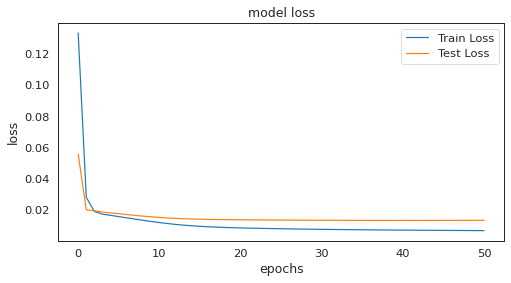

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

Below is the graph of actual and predicted electricity Consumption but here I havetaken logarithmic format of mean of electricity consumption kilo per watt.Here belowcolor notes the actual data , orange notes the trained data and green notes the train data.In the graph its showing overlapping but when you zoom the graph its not perfectlyoverlapping.So by accuracy and loss, I concluded that the model is good but not perfectly fit.

Train Score: 0.03 RMSE
Test Score: 0.04 RMSE


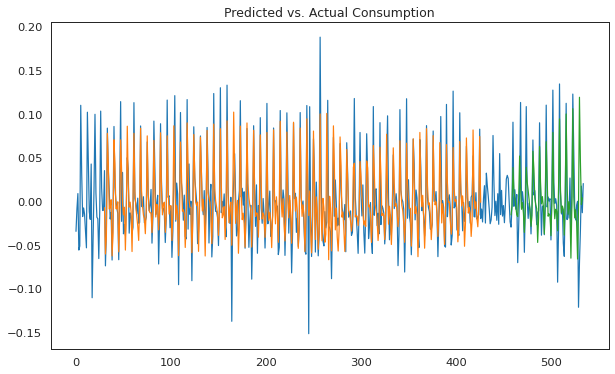

In [ ]:
trainpred = model.predict(X_train)
testpred = model.predict(X_test)

trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])
predictions = testpred

trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainpredPlot = np.empty_like(dataset)
trainpredPlot[:, :] = np.nan
trainpredPlot[look_back:len(trainpred)+look_back, :] = trainpred

testpredPlot = np.empty_like(dataset)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred)+(look_back*2)+1:len(dataset)-1, :] = testpred

inversetransform, =plt.plot(scaler.inverse_transform(dataset))
trainpred, =plt.plot(trainpredPlot)
testpred, =plt.plot(testpredPlot)
plt.title("Predicted vs. Actual Consumption")
plt.show()


# LSTM without Data stationarity 

In [ ]:
dataset = df.ElectricityConsumption.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

I tried to increase performance of my model and hence make changes onechos, batch/size and units of LSTM. The model performance shows best in the below configuration.
1.   epochs=100
2.   batch_size = 30
3.   Lstm units =12
> In the above configuration, the model attained accuracy = 65.8121109008789%













In [ ]:
model = Sequential()
model.add(LSTM(12, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics='accuracy')

history = model.fit(X_train, Y_train, epochs=100, batch_size=30, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/100
14/14 [==============================] - 2s 38ms/step - loss: 0.1926 - accuracy: 8.9400e-04 - val_loss: 0.1950 - val_accuracy: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0843 - accuracy: 8.9400e-04 - val_loss: 0.0924 - val_accuracy: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0321 - accuracy: 8.9400e-04 - val_loss: 0.0419 - val_accuracy: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0134 - accuracy: 8.9400e-04 - val_loss: 0.0245 - val_accuracy: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0100 - accuracy: 8.9400e-04 - val_loss: 0.0216 - val_accuracy: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0095 - accuracy: 8.9400e-04 - val_loss: 0.0231 - val_accuracy: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 0s 5ms/step - loss: 0.0096 - accuracy: 8.9400e-04 - 

In [ ]:
model.save('MusicalInstrumentReviews.h5')
Y_test_dummies = pd.get_dummies(Y_test).values
print('Shape of Label tensor: ', Y_test_dummies.shape)
# model evaluation
from keras.models import load_model

model = load_model('MusicalInstrumentReviews.h5')
scores = model.evaluate(X_test, Y_test_dummies)

LSTM_accuracy = scores[1]*100

print('Test accuracy: ', scores[1]*100, '%')

Shape of Label tensor:  (77, 77)
3/3 [==============================] - 0s 3ms/step - loss: 0.1975 - accuracy: 0.6581
Test accuracy:  65.8121109008789 %


Below is the plot of loss for LSTM. The blue scale denotes the losses suffered inthe training data-set and the yellow scale denotes the losses suffered in the testingdata-set.With the help of this it makes it more easy to understand the behaviour of our model

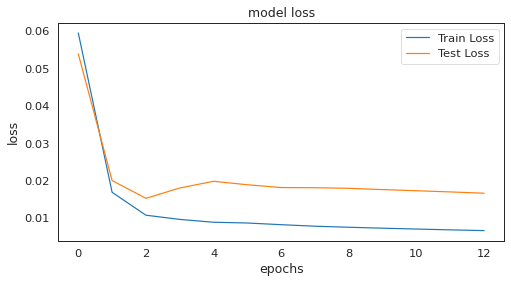

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
trainpred = model.predict(X_train)
testpred = model.predict(X_test)

trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])
predictions = testpred

Below is the graph of actual and predicted electricity Consumption but here I have taken the mean of electricity consumption kilo per watt.Here below color notes the actual data , orange notes the trained data and green notes the train data. In the graphits showing overlapping but when you zoom the graph its not perfectly overlapping.So by accuracy and loss, I concluded that the model is not good and stationary data makes an important role in increasing the performance of the model

Train Score: 0.04 RMSE
Test Score: 0.06 RMSE


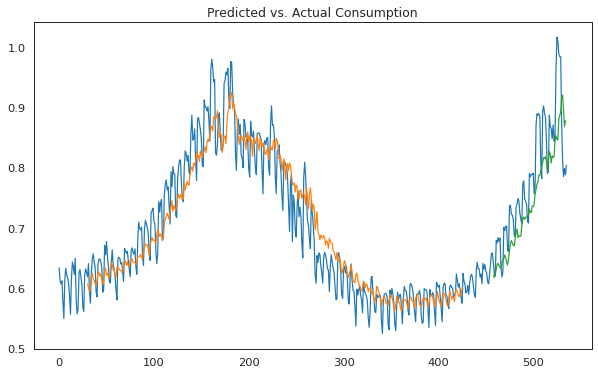

In [ ]:
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainpredPlot = np.empty_like(dataset)
trainpredPlot[:, :] = np.nan
trainpredPlot[look_back:len(trainpred)+look_back, :] = trainpred

testpredPlot = np.empty_like(dataset)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred)+(look_back*2)+1:len(dataset)-1, :] = testpred

inversetransform, =plt.plot(scaler.inverse_transform(dataset))
trainpred, =plt.plot(trainpredPlot)
testpred, =plt.plot(testpredPlot)
plt.title("Predicted vs. Actual Consumption")
plt.show()
